## Setting the environment

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.layers import Flatten, Embedding
from sklearn.model_selection import train_test_split

## Loading dataset

In [2]:
movie_reviews = pd.read_csv("a1_IMDB_Dataset.csv")
# dataset source: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [3]:
movie_reviews.shape

(50000, 2)

In [4]:
movie_reviews.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
movie_reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

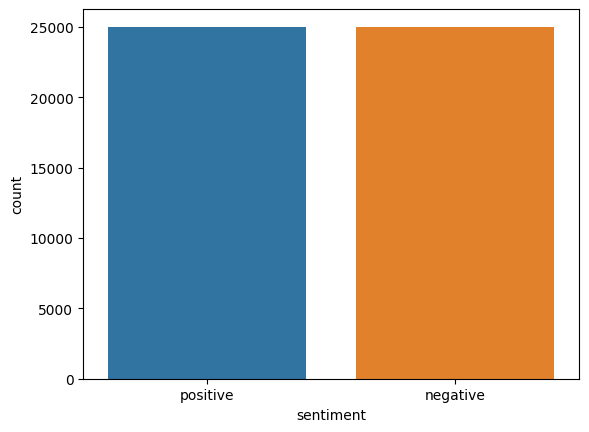

In [6]:
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

## Data Preprocessing

In [7]:
movie_reviews["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [8]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mikil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''
    
    sentence = sen.lower()

    # Remove html tags
    sentence = remove_tags(sentence)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  
    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  
    # Remove Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [11]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [12]:
X[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [13]:
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Preparing embedding layer

Let's now write the script for our embedding layer. Embedding layer converts our textual data into numeric form. It is then **used as the first layer for the deep learning models in Keras**.

In [15]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [16]:
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

92394

In [17]:
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [18]:
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [19]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [20]:
embedding_matrix.shape

(92394, 100)

# Model Training with:

## Simple Neural Network

In [21]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [22]:
# Model compiling

snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9249401 (35.28 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [23]:
snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 2s 4ms/step - loss: 0.5596 - acc: 0.7103 - val_loss: 0.5014 - val_acc: 0.7592
Epoch 2/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4515 - acc: 0.7928 - val_loss: 0.4999 - val_acc: 0.7629
Epoch 3/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4117 - acc: 0.8188 - val_loss: 0.5015 - val_acc: 0.7623
Epoch 4/6
250/250 [==============================] - 1s 4ms/step - loss: 0.3925 - acc: 0.8272 - val_loss: 0.5160 - val_acc: 0.7596
Epoch 5/6
250/250 [==============================] - 1s 5ms/step - loss: 0.3762 - acc: 0.8366 - val_loss: 0.5210 - val_acc: 0.7601
Epoch 6/6
250/250 [==============================] - 1s 4ms/step - loss: 0.3651 - acc: 0.8413 - val_loss: 0.5309 - val_acc: 0.7566


In [24]:
score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 0s 1ms/step - loss: 0.5588 - acc: 0.7463


In [25]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5587651133537292
Test Accuracy: 0.7462999820709229


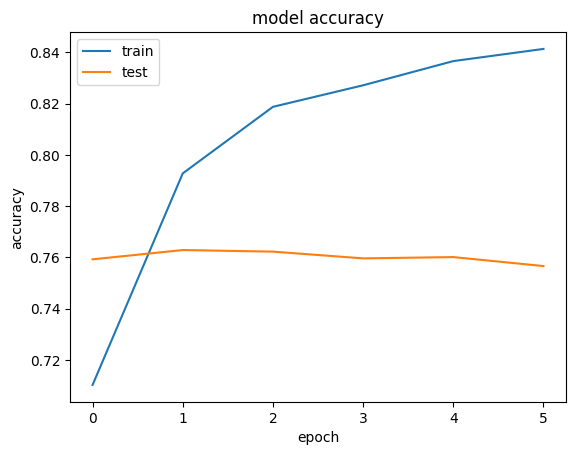

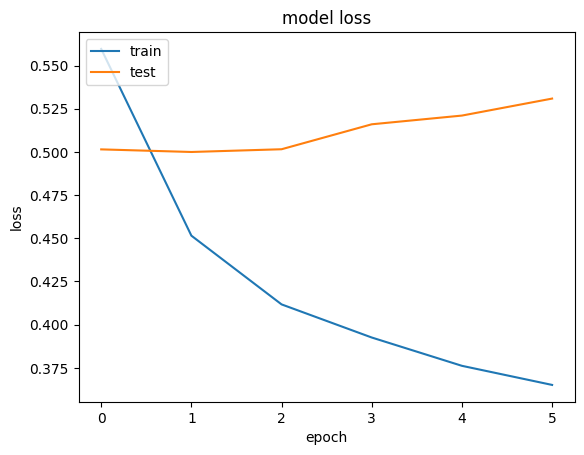

In [26]:
import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()